In [ ]:
# 1) Configuration & Reproducibility
import os, random, json, math, time
from pathlib import Path
import numpy as np
import torch

print("start")

CFG = {
    "paths": {
        # Root directory containing videos like: case_<VideoID>.mp4
        "video_root": "data/videos",
        # Annotations CSV with columns: VideoID, Start, End, PhaseID (Start/End at 25 fps)
        "annotations": "data/annotations.csv",
        "out_dir": "outputs_swin"
    },
    "data": {
        "fps_original": 25,
        "fps_sample": 10,        # extracted fps
        "clip_len": 32,          # frames per clip (~3.2 s at 10 fps)
        "resize": [224, 224],
        "num_classes": 10,
        "val_split": 0.2,
        "stride_eval": 8          # temporal stride for evaluation stitching
    },
    "train": {
        "batch_size": 4,
        "num_workers": 4,
        "seed": 42,
        "epochs": 25,
        "patience": 10,
        "lr": 3e-4,
        "weight_decay": 1e-4,
        "label_smoothing": 0.1
    }
}

Path(CFG["paths"]["out_dir"]).mkdir(parents=True, exist_ok=True)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG["train"]["seed"])

print("Done ✅")

start
Done ✅


In [5]:
# 2) Dataset utilities: loading annotations, frame sampling, clip extraction
import pandas as pd
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SurgicalClips(Dataset):
    """Dataset that samples fixed-length clips from phase segments within videos.
       Assumes an annotations CSV with columns: VideoID, Start, End, PhaseID (1..num_classes), at 25 fps.
    """
    def __init__(self, csv_path, video_root, clip_len=32, fps_sample=10, resize=(224,224),
                 transform=None, split_vids=None, mode="train"):
        self.data = pd.read_csv(csv_path)
        self.data = self.data.sort_values(["VideoID", "Start"]).reset_index(drop=True)
        if split_vids is not None:
            self.data = self.data[self.data["VideoID"].isin(split_vids)].reset_index(drop=True)
        self.video_root = Path(video_root)
        self.clip_len = clip_len
        self.fps_sample = fps_sample
        self.resize = tuple(resize)
        self.transform = transform
        self.mode = mode
        self.fps_annot = 25

        # Pre-build an index of (video_path, start_frame, phase_label) for faster __getitem__
        self.index = []
        for _, row in self.data.iterrows():
            vid = int(row.VideoID)
            path = self.video_root / f"case_{vid}.mp4"
            seg_start = int(row.Start * self.fps_sample / self.fps_annot)
            seg_end   = int(row.End   * self.fps_sample / self.fps_annot)
            if seg_end <= seg_start:
                continue
            # Build multiple starting points per segment (overlapping windows) to expand data
            step = self.clip_len // 2  # 50% overlap
            starts = list(range(seg_start, max(seg_start+1, seg_end - self.clip_len + 1), step))
            if len(starts) == 0:
                starts = [max(seg_start, seg_end - self.clip_len)]
            y = int(row.PhaseID) - 1  # to 0..num_classes-1
            for s in starts:
                self.index.append((path, s, y))

    def __len__(self):
        return len(self.index)

    def _read_clip(self, path, start):
        cap = cv2.VideoCapture(str(path))
        if not cap.isOpened():
            raise FileNotFoundError(f"Video not found: {path}")
        cap.set(cv2.CAP_PROP_POS_FRAMES, start)
        frames = []
        for _ in range(self.clip_len):
            ret, f = cap.read()
            if not ret:
                break
            f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
            f = cv2.resize(f, self.resize, interpolation=cv2.INTER_AREA)
            frames.append(f)
        cap.release()
        # Pad/trim to fixed length
        if len(frames) == 0:
            # create a dummy black clip if read fails
            frames = [np.zeros((self.resize[1], self.resize[0], 3), dtype=np.uint8) for _ in range(self.clip_len)]
        if len(frames) < self.clip_len:
            last = frames[-1]
            while len(frames) < self.clip_len:
                frames.append(last)
        frames = frames[:self.clip_len]
        x = np.stack(frames)  # [T, H, W, C]
        x = torch.tensor(x).permute(0,3,1,2).float() / 255.0  # [T, C, H, W]
        return x

    def __getitem__(self, idx):
        path, start, y = self.index[idx]
        x = self._read_clip(path, start)
        # apply per-frame transforms if provided
        if self.transform is not None:
            x = torch.stack([self.transform(frame) for frame in x])  # [T, C, H, W]
        x = x.permute(1,0,2,3).contiguous()  # [C, T, H, W]
        return x, y

print("Done ✅")

Done ✅


In [9]:
import pandas as pd

ann = pd.read_csv("data/annotations.csv", sep=';')
ann.columns = ann.columns.str.strip().str.replace("\ufeff", "", regex=True)
print(ann.columns)
print(ann.head())



Index(['VideoID', 'FrameNo', 'Phase'], dtype='object')
   VideoID  FrameNo  Phase
0      269       68      1
1      269     1043      2
2      269     1228      3
3      269     2118      4
4      269     3478      5


In [4]:
segments = []
for vid, df in ann.groupby("VideoID"):
    df = df.sort_values("FrameNo").reset_index(drop=True)
    start_idx = 0
    for i in range(1, len(df)):
        if df.loc[i, "Phase"] != df.loc[i-1, "Phase"]:
            phase = int(df.loc[i-1, "Phase"])
            start = int(df.loc[start_idx, "FrameNo"])
            end = int(df.loc[i-1, "FrameNo"])
            segments.append((vid, start, end, phase))
            start_idx = i
    if len(df) > 0:
        phase = int(df.loc[len(df)-1, "Phase"])
        start = int(df.loc[start_idx, "FrameNo"])
        end = int(df.loc[len(df)-1, "FrameNo"])
        segments.append((vid, start, end, phase))

segments_df = pd.DataFrame(segments, columns=["VideoID", "Start", "End", "PhaseID"])
segments_df.to_csv("data/annotations_segments.csv", index=False)
print("✅ Segment-level annotations saved:", len(segments_df))




✅ Segment-level annotations saved: 1173


In [6]:
CFG["paths"]["annotations"] = "data/annotations_segments.csv"
print("Done ✅")

Done ✅


In [7]:
import os, torch, torch.multiprocessing as mp
mp.set_sharing_strategy('file_system')     # avoid /dev/shm
os.environ.setdefault("PYTORCH_DISABLE_SHM", "1")  # extra guard (harmless if ignored)
import cv2
cv2.setNumThreads(0)  # make OpenCV behave in workers
print("Done ✅")

Done ✅


In [8]:
# ============================================================
# 3) Train/Val split (Segment-level stratification) + Balanced sampler
# ============================================================
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
import numpy as np
import pandas as pd
import torch
from torchvision import transforms

# ------------------------------------------------------------
# Load annotations
# ------------------------------------------------------------
ann = pd.read_csv(CFG["paths"]["annotations"]).sort_values(["VideoID", "Start"]).reset_index(drop=True)

# Each row corresponds to a labeled segment with a PhaseID
X = ann.index.values                      # segment indices
y = ann["PhaseID"].values                 # labels per segment

# Stratified segment-level split
train_idx, val_idx = train_test_split(
    X,
    test_size=CFG["data"]["val_split"],
    random_state=CFG["train"]["seed"],
    stratify=y
)

# Extract unique VideoIDs from those segments
train_vids = ann.loc[train_idx, "VideoID"].unique()
val_vids   = ann.loc[val_idx,   "VideoID"].unique()

print(f"Train videos: {len(train_vids)}, Val videos: {len(val_vids)}")
print("Train label distribution:\n", pd.Series(y[train_idx]).value_counts().sort_index())
print("Val label distribution:\n",   pd.Series(y[val_idx]).value_counts().sort_index())

# ------------------------------------------------------------
# Data augmentation
# ------------------------------------------------------------
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(CFG["data"]["resize"][0], scale=(0.6,1.0), antialias=True),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.Normalize(mean=[0.45,0.45,0.45], std=[0.225,0.225,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize(CFG["data"]["resize"][0], antialias=True),
    transforms.CenterCrop(CFG["data"]["resize"][0]),
    transforms.Normalize(mean=[0.45,0.45,0.45], std=[0.225,0.225,0.225])
])

# ------------------------------------------------------------
# Dataset objects
# ------------------------------------------------------------
train_ds = SurgicalClips(
    CFG["paths"]["annotations"], CFG["paths"]["video_root"],
    clip_len=CFG["data"]["clip_len"], fps_sample=CFG["data"]["fps_sample"],
    resize=CFG["data"]["resize"], transform=train_tf, split_vids=train_vids, mode="train"
)

val_ds = SurgicalClips(
    CFG["paths"]["annotations"], CFG["paths"]["video_root"],
    clip_len=CFG["data"]["clip_len"], fps_sample=CFG["data"]["fps_sample"],
    resize=CFG["data"]["resize"], transform=val_tf, split_vids=val_vids, mode="val"
)

# ------------------------------------------------------------
# Weighted sampler (balances per-class frequency in training)
# ------------------------------------------------------------
labels = [y for _, y in train_ds]
class_counts = np.bincount(labels, minlength=CFG["data"]["num_classes"])
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = [class_weights[y] for y in labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=CFG["train"]["batch_size"],
    sampler=sampler,          # balanced sampling
    shuffle=False,            # must be False when using sampler
    num_workers=0,
    pin_memory=False,
    persistent_workers=False,
    prefetch_factor=None,
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG["train"]["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False,
    prefetch_factor=None,
)

# ------------------------------------------------------------
# Weighted CrossEntropy loss (inverse-frequency)
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

phase_counts = ann["PhaseID"].value_counts().sort_index()
weights = 1.0 / phase_counts
weights = weights / weights.sum()
weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)

criterion = torch.nn.CrossEntropyLoss(
    weight=weights_tensor,
    label_smoothing=CFG["train"]["label_smoothing"]
)

print("Train clips:", len(train_ds), "Val clips:", len(val_ds))
print("Per-class counts (train):", class_counts)
print("Done ✅")


Train videos: 101, Val videos: 88
Train label distribution:
 1      82
2     173
3      83
4      81
5      82
6      96
7      88
8      83
9      84
10     86
Name: count, dtype: int64
Val label distribution:
 1     21
2     43
3     21
4     20
5     21
6     24
7     22
8     21
9     21
10    21
Name: count, dtype: int64
Train clips: 1323 Val clips: 1122
Per-class counts (train): [  19  146    0    0   40    0    0   52   37 1029]
Done ✅


In [10]:
# 4) Build Video Swin model (pretrained) and replace head
from transformers import VideoMAEForVideoClassification, get_cosine_schedule_with_warmup
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torch.optim import AdamW
from tqdm import tqdm
from torch import amp

def build_videomae(num_classes=10, pretrained=True):
    """
    VideoMAE base backbone for surgical video classification.
    Includes dropout + partial freeze for better generalization.
    """
    model_name = "MCG-NJU/videomae-base"
    print(f"🔹 Loading pretrained VideoMAE model: {model_name}")

    model = VideoMAEForVideoClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
    )

    # # ---- Replace classifier head with Dropout + Linear ----
    # in_features = (
    #     model.classifier.in_features
    #     if hasattr(model.classifier, "in_features")
    #     else model.classifier[0].in_features
    # )
    # model.classifier = nn.Sequential(
    #     nn.Dropout(0.3),                        # 🔹 new: strong regularization
    #     nn.Linear(in_features, num_classes)
    # )

    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_videomae(num_classes=CFG["data"]["num_classes"], pretrained=True)

# ---- Resize positional embeddings ----
def resize_videomae_pos_embed(model, new_temporal_len=32, new_size=(224, 224)):
    """
    Fully safe VideoMAE positional embedding resizer.
    Works even if pretrained grid is non-integer (e.g. 7.84×14×14).
    """
    pos_embed = model.videomae.embeddings.position_embeddings  # [1, N, D]
    embed_dim = pos_embed.shape[-1]
    pos_tokens = pos_embed[:, 1:, :]  # drop cls token
    num_patches_old = pos_tokens.shape[1]

    patch_size = model.config.patch_size
    tubelet_size = model.config.tubelet_size
    img_size = model.config.image_size
    old_spatial = img_size // patch_size

    # infer temporal dimension as float, then round safely
    old_temporal_f = num_patches_old / (old_spatial * old_spatial)
    old_temporal = int(round(old_temporal_f))
    print(f"ℹ️ Inferred temporal={old_temporal_f:.3f} → rounded to {old_temporal}")

    # pad or trim to make reshape valid
    needed = old_temporal * old_spatial * old_spatial
    if needed > num_patches_old:
        pad = needed - num_patches_old
        pos_tokens = torch.cat([pos_tokens, pos_tokens[:, :pad, :]*0], dim=1)
        print(f"⚙️ Padded {pad} tokens to fit reshape grid ({needed})")
    elif needed < num_patches_old:
        pos_tokens = pos_tokens[:, :needed, :]
        print(f"⚙️ Trimmed {num_patches_old - needed} tokens to fit reshape grid ({needed})")

    # reshape + interpolate
    pos_tokens = pos_tokens.reshape(1, old_temporal, old_spatial, old_spatial, embed_dim).permute(0, 4, 1, 2, 3)
    new_temporal = new_temporal_len // tubelet_size
    new_spatial = new_size[0] // patch_size
    print(f"ℹ️ Target grid: T={new_temporal}, H={new_spatial}, W={new_spatial}")

    pos_tokens = F.interpolate(
        pos_tokens,
        size=(new_temporal, new_spatial, new_spatial),
        mode="trilinear",
        align_corners=False
    )

    pos_tokens = pos_tokens.permute(0, 2, 3, 4, 1).reshape(1, -1, embed_dim)
    model.videomae.embeddings.position_embeddings = torch.nn.Parameter(pos_tokens)
    print(f"✅ Resized pos_embed: {num_patches_old} → {pos_tokens.shape[1]}")

    
resize_videomae_pos_embed(model, new_temporal_len=CFG["data"]["clip_len"], new_size=(224, 224))

model = model.to(device)
# ---- Partial freeze (keep early layers fixed) ----
for name, param in model.videomae.named_parameters():
    if "encoder.layer" in name and int(name.split(".")[2]) < 8:
        param.requires_grad = False     # freeze first 8 blocks
    else:
        param.requires_grad = True      # train last 4 blocks + norm/head

# ---- Optimizer with different LRs ----
optimizer = AdamW([
    {'params': model.videomae.parameters(), 'lr': 1e-5},  # was 1e-5
    {'params': model.classifier.parameters(), 'lr': 1e-4},
], weight_decay=1e-3) 

# ---- LR scheduler ----
num_warmup_steps = len(train_loader) * 3
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(train_loader) * CFG["train"]["epochs"]
)

# ---- AMP GradScaler ----
scaler = amp.GradScaler(device="cuda")

best_path = os.path.join(CFG["paths"]["out_dir"], "swin_best.pth")

print("✅ Model ready with dropout, partial freeze, and stronger regularization")

🔹 Loading pretrained VideoMAE model: MCG-NJU/videomae-base


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 68e369e5-859e-4ba9-bb31-f9e670c74e1b)')' thrown while requesting HEAD https://huggingface.co/MCG-NJU/videomae-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 07c38e2f-4d2e-4566-8a92-860bad64f2d7)')' thrown while requesting HEAD https://huggingface.co/MCG-NJU/videomae-base/resolve/main/config.json
Retrying in 2s [Retry 2/5].
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ℹ️ Inferred temporal=7.995 → rounded to 8
⚙️ Padded 1 tokens to fit reshape grid (1568)
ℹ️ Target grid: T=16, H=14, W=14
✅ Resized pos_embed: 1567 → 3136
✅ Model ready with dropout, partial freeze, and stronger regularization


In [11]:
print("✅ start")
all_labels = torch.tensor([y for _, y in train_ds])
print("Min label:", all_labels.min().item(), "Max label:", all_labels.max().item())


✅ start


In [12]:
# 5) Training loop with AMP, early stopping

from torch import amp

def train_one_epoch(model, loader):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for X, y in tqdm(loader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast("cuda", dtype=torch.float32):
            X = X.permute(0, 2, 1, 3, 4)   # [B,C,T,H,W] -> [B,T,C,H,W]
            yhat = model(X).logits
            loss = criterion(yhat, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item() * y.size(0)
        correct += (yhat.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total


@torch.inference_mode()
def validate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for X, y in loader:
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        X = X.permute(0, 2, 1, 3, 4)
        yhat = model(X).logits
        loss_sum += criterion(yhat, y).item() * y.size(0)
        correct += (yhat.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total


best_val_acc, best_val_loss = 0.0, float("inf")
epochs_no_improve = 0

for epoch in range(1, CFG["train"]["epochs"] + 1):
    # unfreeze backbone after 5 epochs
    if epoch == 5:
        for param in model.videomae.parameters():
            param.requires_grad = True
        print("✅ Unfroze VideoMAE backbone")

    print(f"\nEpoch {epoch}/{CFG['train']['epochs']}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)
    scheduler.step()
    print(f"Train: loss={tr_loss:.3f}, acc={tr_acc:.3f} | Val: loss={val_loss:.3f}, acc={val_acc:.3f}")

    improved = val_loss < best_val_loss
    if improved:
        best_val_loss = val_loss
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        epochs_no_improve = 0
        print("  ✅ Saved new best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= CFG["train"]["patience"]:
            print("⏹️ Early stopping")
            break

print(f"\n🏁 Best Val Acc = {best_val_acc:.3f}; Best Val Loss = {best_val_loss:.3f}")



Epoch 1/25


100% 331/331 [14:48<00:00,  2.68s/it]


Train: loss=2.402, acc=0.045 | Val: loss=2.226, acc=0.071
  ✅ Saved new best model

Epoch 2/25


100% 331/331 [15:01<00:00,  2.72s/it]


Train: loss=2.406, acc=0.039 | Val: loss=2.221, acc=0.093
  ✅ Saved new best model

Epoch 3/25


100% 331/331 [14:20<00:00,  2.60s/it]


Train: loss=2.401, acc=0.048 | Val: loss=2.213, acc=0.142
  ✅ Saved new best model

Epoch 4/25


100% 331/331 [14:34<00:00,  2.64s/it]


Train: loss=2.385, acc=0.059 | Val: loss=2.201, acc=0.243
  ✅ Saved new best model
✅ Unfroze VideoMAE backbone

Epoch 5/25


100% 331/331 [14:57<00:00,  2.71s/it]


Train: loss=2.332, acc=0.089 | Val: loss=2.179, acc=0.314
  ✅ Saved new best model

Epoch 6/25


100% 331/331 [14:42<00:00,  2.67s/it]


Train: loss=2.290, acc=0.137 | Val: loss=2.156, acc=0.313
  ✅ Saved new best model

Epoch 7/25


100% 331/331 [14:53<00:00,  2.70s/it]


Train: loss=2.221, acc=0.183 | Val: loss=2.133, acc=0.309
  ✅ Saved new best model

Epoch 8/25


100% 331/331 [14:58<00:00,  2.72s/it]


Train: loss=2.177, acc=0.190 | Val: loss=2.119, acc=0.266
  ✅ Saved new best model

Epoch 9/25


100% 331/331 [15:00<00:00,  2.72s/it]


Train: loss=2.119, acc=0.184 | Val: loss=2.102, acc=0.259
  ✅ Saved new best model

Epoch 10/25


100% 331/331 [14:46<00:00,  2.68s/it]


Train: loss=2.073, acc=0.198 | Val: loss=2.074, acc=0.477
  ✅ Saved new best model

Epoch 11/25


100% 331/331 [14:45<00:00,  2.67s/it]


Train: loss=2.017, acc=0.234 | Val: loss=2.057, acc=0.598
  ✅ Saved new best model

Epoch 12/25


100% 331/331 [14:38<00:00,  2.65s/it]


Train: loss=1.969, acc=0.272 | Val: loss=2.041, acc=0.616
  ✅ Saved new best model

Epoch 13/25


100% 331/331 [14:44<00:00,  2.67s/it]


Train: loss=1.933, acc=0.303 | Val: loss=2.033, acc=0.624
  ✅ Saved new best model

Epoch 14/25


100% 331/331 [14:38<00:00,  2.65s/it]


Train: loss=1.886, acc=0.372 | Val: loss=2.003, acc=0.683
  ✅ Saved new best model

Epoch 15/25


100% 331/331 [14:44<00:00,  2.67s/it]


Train: loss=1.838, acc=0.438 | Val: loss=1.974, acc=0.678
  ✅ Saved new best model

Epoch 16/25


100% 331/331 [14:48<00:00,  2.69s/it]


Train: loss=1.782, acc=0.550 | Val: loss=1.933, acc=0.688
  ✅ Saved new best model

Epoch 17/25


100% 331/331 [14:26<00:00,  2.62s/it]


Train: loss=1.679, acc=0.656 | Val: loss=1.896, acc=0.664
  ✅ Saved new best model

Epoch 18/25


100% 331/331 [14:33<00:00,  2.64s/it]


Train: loss=1.514, acc=0.728 | Val: loss=1.875, acc=0.642
  ✅ Saved new best model

Epoch 19/25


100% 331/331 [14:35<00:00,  2.64s/it]


Train: loss=1.364, acc=0.740 | Val: loss=1.865, acc=0.486
  ✅ Saved new best model

Epoch 20/25


100% 331/331 [15:10<00:00,  2.75s/it]


Train: loss=1.194, acc=0.751 | Val: loss=1.812, acc=0.594
  ✅ Saved new best model

Epoch 21/25


100% 331/331 [15:00<00:00,  2.72s/it]


Train: loss=1.068, acc=0.779 | Val: loss=1.795, acc=0.537
  ✅ Saved new best model

Epoch 22/25


100% 331/331 [14:55<00:00,  2.71s/it]


Train: loss=0.995, acc=0.765 | Val: loss=1.749, acc=0.645
  ✅ Saved new best model

Epoch 23/25


100% 331/331 [14:53<00:00,  2.70s/it]


Train: loss=0.916, acc=0.810 | Val: loss=1.715, acc=0.701
  ✅ Saved new best model

Epoch 24/25


100% 331/331 [15:15<00:00,  2.76s/it]


Train: loss=0.857, acc=0.857 | Val: loss=1.713, acc=0.649
  ✅ Saved new best model

Epoch 25/25


100% 331/331 [14:59<00:00,  2.72s/it]


Train: loss=0.796, acc=0.889 | Val: loss=1.681, acc=0.695
  ✅ Saved new best model

🏁 Best Val Acc = 0.695; Best Val Loss = 1.681



Averaged stitched metrics:
  raw_acc: 0.711
  med_acc: 0.711
  vote_acc: 0.711
  raw_f1: 0.628
  med_f1: 0.628
  vote_f1: 0.628

Classification report (timeline, voted):
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       152
           1      0.000     0.000     0.000      1120
           4      0.000     0.000     0.000       320
           7      0.133     0.635     0.220       416
           9      0.855     0.858     0.856      6968

    accuracy                          0.695      8976
   macro avg      0.198     0.298     0.215      8976
weighted avg      0.670     0.695     0.675      8976



/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


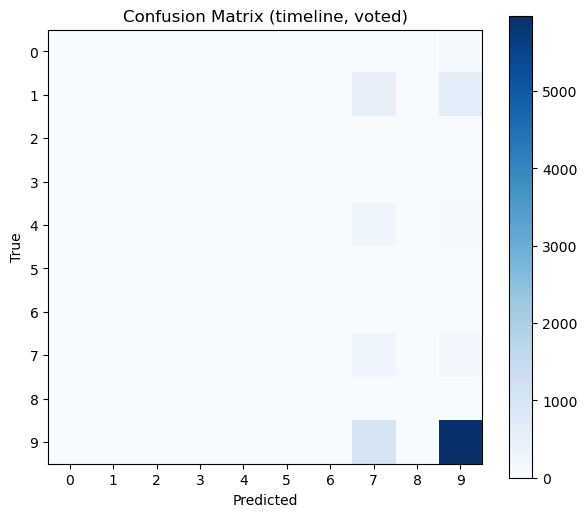

In [17]:
# 6) Evaluation: per-video stitching with median filter and local majority vote
from collections import defaultdict
from scipy.signal import medfilt
from scipy.stats import mode
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

@torch.inference_mode()
def get_video_clips(ds, vid, clip_len, stride):
    # gather validation indices for a given video id
    idxs = [i for i,(p, s, y) in enumerate(ds.index) if int(p.name.split('_')[1].split('.')[0]) == int(vid)]
    # create sliding windows across the whole video range covered by annots
    # For simplicity, reuse ds._read_clip and ds.index starts as anchors
    clips, anchors, labels = [], [], []
    for i in idxs:
        p, s, y = ds.index[i]
        x = ds._read_clip(p, s)
        x = torch.stack([val_tf(frame) for frame in x])  # per-frame
        x = x.permute(1,0,2,3).contiguous()  # [C,T,H,W]
        clips.append(x)
        anchors.append(s)
        labels.append(y)
    return clips, anchors, labels

@torch.inference_mode()
def evaluate_stitched(model_path, ds_val, stride=8):
    # model = build_swin(num_classes=CFG["data"]["num_classes"], pretrained=False).to(device)
    # model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    vids = sorted(ds_val.data["VideoID"].unique())
    metrics = {}
    all_preds, all_tgts = [], []

    for vid in vids:
        clips, anchors, labels = get_video_clips(ds_val, vid, CFG["data"]["clip_len"], stride)
        probs = []
        for x in clips:
            x = x.unsqueeze(0).to(device, non_blocking=True)  # [1,C,T,H,W]
            x = x.permute(0, 2, 1, 3, 4)                     # ✅ [1,T,C,H,W]
            with torch.inference_mode():
                yhat = model(x)
                yhat = yhat.logits if hasattr(yhat, "logits") else yhat
                p = yhat.softmax(1).cpu().numpy()
            probs.append(p)
            del x
            torch.cuda.empty_cache()

        if len(probs) == 0:
            continue
        probs = np.concatenate(probs)  # [Nclips, C]
        pred_clips = probs.argmax(1)

        # Stitching: repeat each clip prediction for 'stride' frames
        timeline = np.repeat(pred_clips, stride)
        # Median filter to stabilize
        k = 7 if len(timeline) >= 7 else (len(timeline)//2*2+1)
        timeline_med = medfilt(timeline, kernel_size=k)
        # Local voting in a sliding window
        window = 11
        timeline_vote = np.copy(timeline)
        for i in range(len(timeline)):
            a = max(0, i - window//2)
            b = min(len(timeline), i + window//2 + 1)
            timeline_vote[i] = mode(timeline[a:b], keepdims=True)[0][0]

        # Build pseudo-ground truth by repeating labels per anchor region length
        # (If you have exact frame-level GT, replace this with the true timeline.)
        gt = np.repeat(np.array(labels), stride)
        n = min(len(gt), len(timeline))
        gt, timeline, timeline_med, timeline_vote = gt[:n], timeline[:n], timeline_med[:n], timeline_vote[:n]

        m = {
            "raw_acc":  accuracy_score(gt, timeline),
            "med_acc":  accuracy_score(gt, timeline_med),
            "vote_acc": accuracy_score(gt, timeline_vote),
            "raw_f1":   f1_score(gt, timeline, average="macro"),
            "med_f1":   f1_score(gt, timeline_med, average="macro"),
            "vote_f1":  f1_score(gt, timeline_vote, average="macro"),
        }
        metrics[vid] = m
        all_preds.extend(timeline_vote.tolist())
        all_tgts.extend(gt.tolist())

    # Aggregate metrics
    if len(metrics) == 0:
        print("No videos evaluated. Check paths/annotations.")
        return {}, {}
    keys = list(metrics.values())[0].keys()
    avg = {k: float(np.mean([metrics[v][k] for v in metrics])) for k in keys}
    print("\nAveraged stitched metrics:")
    for k,v in avg.items():
        print(f"  {k}: {v:.3f}")

    # Confusion matrix over all frames (after voting)
    cm = confusion_matrix(all_tgts, all_preds, labels=list(range(CFG["data"]["num_classes"])))
    print("\nClassification report (timeline, voted):")
    print(classification_report(all_tgts, all_preds, digits=3))

    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title('Confusion Matrix (timeline, voted)')
    plt.colorbar(im, ax=ax)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_xticks(range(CFG["data"]["num_classes"]))
    ax.set_yticks(range(CFG["data"]["num_classes"]))
    plt.show()
    return avg, metrics

avg_metrics, per_vid = evaluate_stitched(best_path, val_ds, stride=CFG["data"]["stride_eval"])